<h1><center>Twitter Airline Tweets' Sentiment Analysis</h1>

## Installing Dependencies

In [ ]:
# !pip install nlpaug
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.2 MB/s eta 0:00:00


## Importing Necessary Modules
In this cell, we import all the necessary modules required for our analysis. This includes pandas for data manipulation, matplotlib and seaborn for data visualization, and various components from keras for building and training our neural network models.

In [ ]:
import os
from getpass import getpass
import urllib
import zipfile
import pandas as pd
import numpy as np
import re
import string

from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import sklearn.naive_bayes
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

import nltk
import subprocess

from tensorflow.keras.layers import LSTM, Conv1D, Dropout, MaxPooling1D, Flatten, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split  # Added this import
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np  # Added this import
import nlpaug.augmenter.word.context_word_embs as aug



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### The below code can be used to get data via kaggle API

In [ ]:
# # Set Kaggle Username and API Key
# os.environ['KAGGLE_USERNAME'] = "username" # replace with your Kaggle username
# os.environ['KAGGLE_KEY'] = "kagglekey" # replace with your Kaggle key

# # Download the dataset
# !kaggle datasets download -d crowdflower/twitter-airline-sentiment

# with zipfile.ZipFile("twitter-airline-sentiment.zip","r") as zip_ref:
#     zip_ref.extractall("twitter-airline-sentiment")


## Loading the Dataset
We load our dataset from a CSV file using pandas. Our dataset consists of tweets about various airlines, along with sentiment labels.

In [ ]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Exploring the Dataset

In [ ]:
df.shape

(14640, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Checking for Missing Values
Missing values can cause issues with some machine learning algorithms, so it's important to check for them. If any are found, they'll need to be handled before training our models.

In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

## Data Visualization

Tweets per sentiment:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


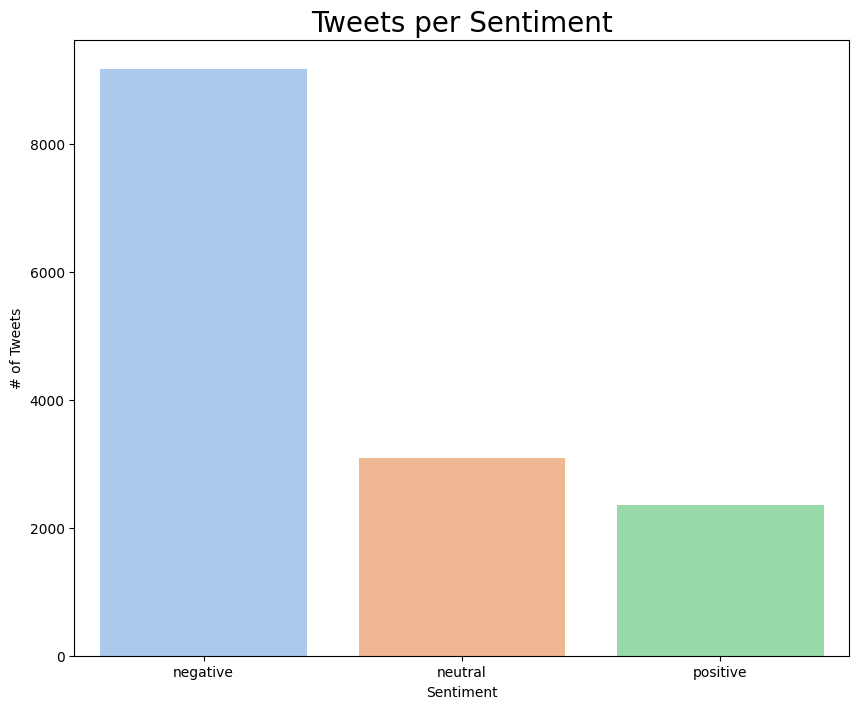

In [ ]:
print("Tweets per sentiment:")
print(df.airline_sentiment.value_counts())

# Define a custom color palette
colors = ['#FF0000', '#00FF00', '#0000FF']

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='airline_sentiment', data=df, order=df.airline_sentiment.value_counts().index, palette="pastel")
ax.set_title('Tweets per Sentiment', fontsize=20)
plt.xlabel('Sentiment')
plt.ylabel('# of Tweets')
plt.show()

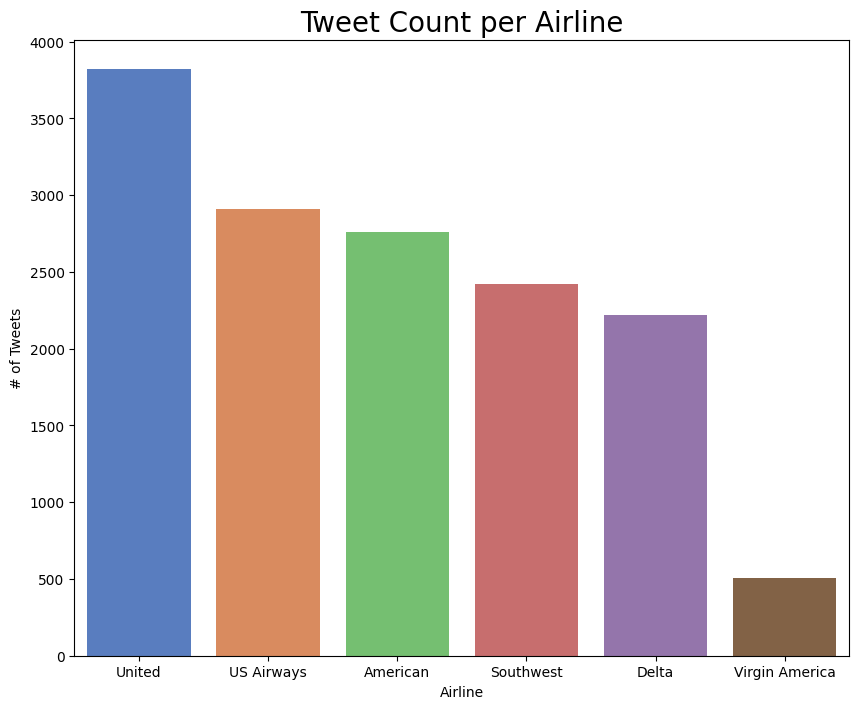

Total Tweet Count vs Airline
United :
negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64
US Airways :
negative    2263
neutral      381
positive     269
Name: airline_sentiment, dtype: int64
American :
negative    1960
neutral      463
positive     336
Name: airline_sentiment, dtype: int64
Southwest :
negative    1186
neutral      664
positive     570
Name: airline_sentiment, dtype: int64
Delta :
negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64
Virgin America :
negative    181
neutral     171
positive    152
Name: airline_sentiment, dtype: int64


In [ ]:
colors = sns.color_palette('muted', 8)
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='airline', data=df, order=df['airline'].value_counts().index, palette=colors)
ax.set_title('Tweet Count per Airline', fontsize=20)
plt.xlabel('Airline')
plt.ylabel('# of Tweets')
plt.show()

print("Total Tweet Count vs Airline")
airline_list = df['airline'].unique().tolist()
tweet_count = df['airline'].value_counts()
for airline in tweet_count.index:
    print('{} :'.format(airline))
    print(df.loc[df['airline'] == airline, 'airline_sentiment'].value_counts())

Reasons Of Negative Tweets:
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


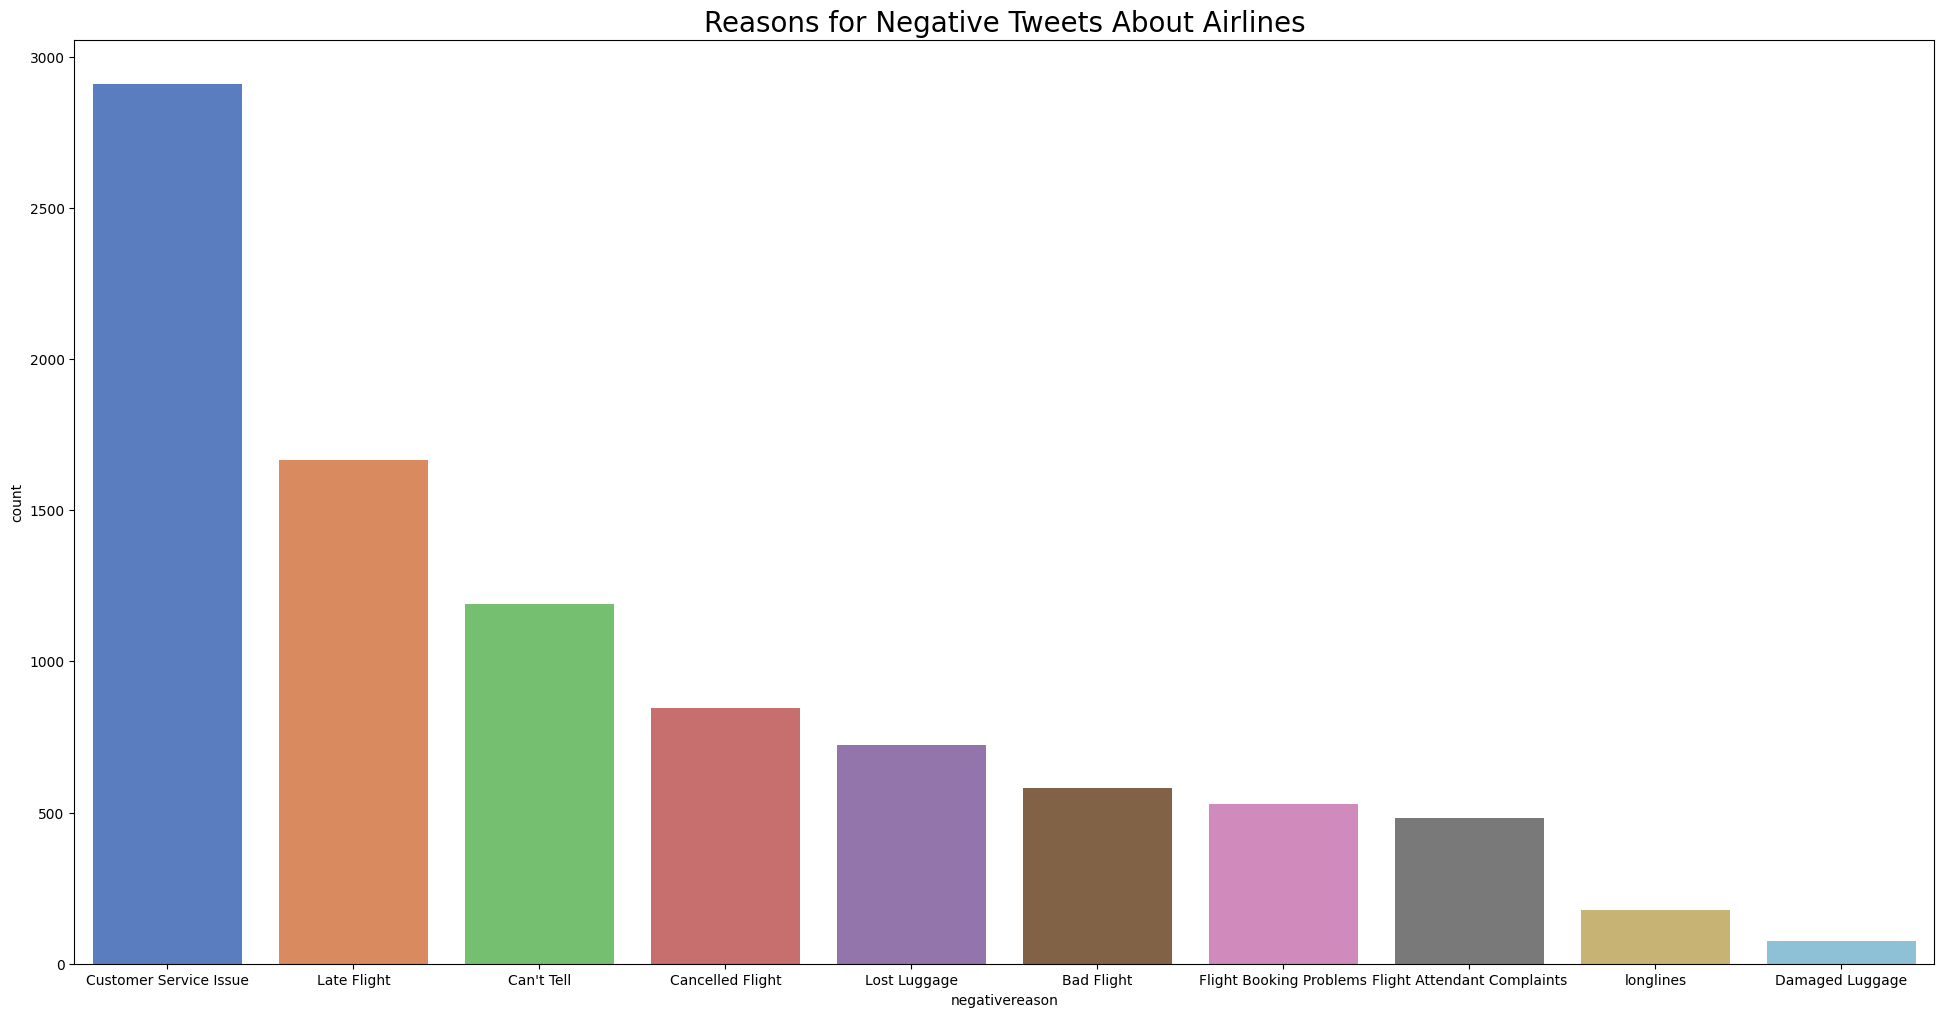

In [ ]:
print('Reasons Of Negative Tweets:')
negative_reason_counts = df['negativereason'].value_counts().sort_values(ascending=False)
print(negative_reason_counts)

plt.figure(figsize=(24, 12))
sns.countplot(x='negativereason', data=df, order=negative_reason_counts.index, palette='muted')
plt.title('Reasons for Negative Tweets About Airlines', fontsize=20)
plt.show()

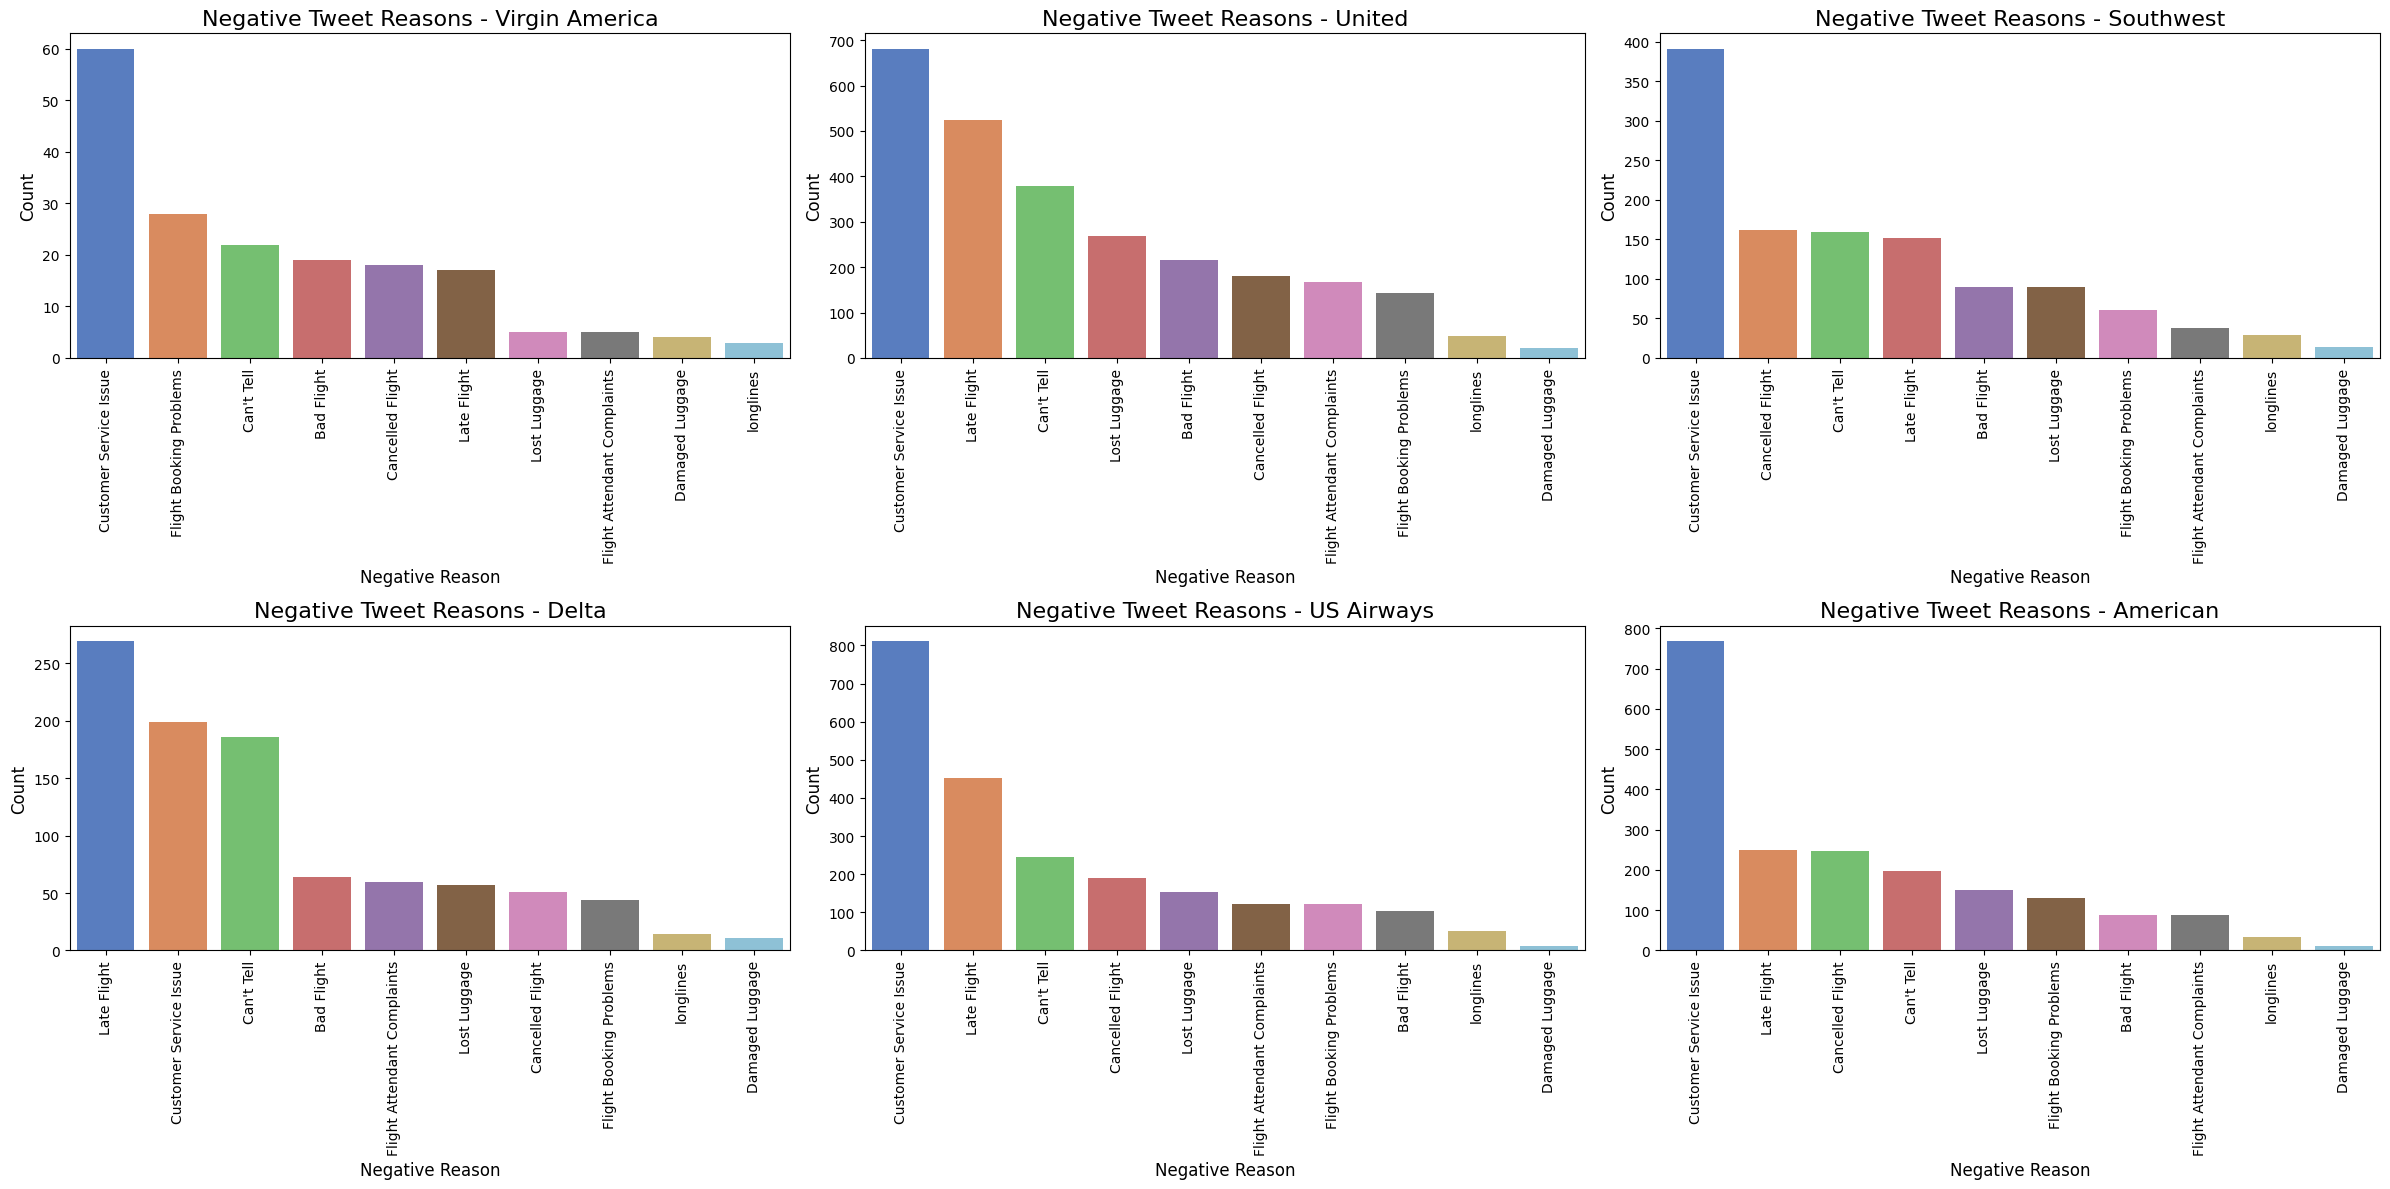

In [ ]:
airlines = df['airline'].unique()

plt.figure(figsize=(24, 12))

for i, airline in enumerate(airlines):
    plt.subplot(2, 3, i+1)
    neg_reason_counts = df[df['airline'] == airline]['negativereason'].value_counts().sort_values(ascending=False)
    sns.countplot(x='negativereason', data=df[df['airline'] == airline], palette='muted', order=neg_reason_counts.index)
    plt.title(f'Negative Tweet Reasons - {airline}', fontsize=16)
    plt.xlabel('Negative Reason', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

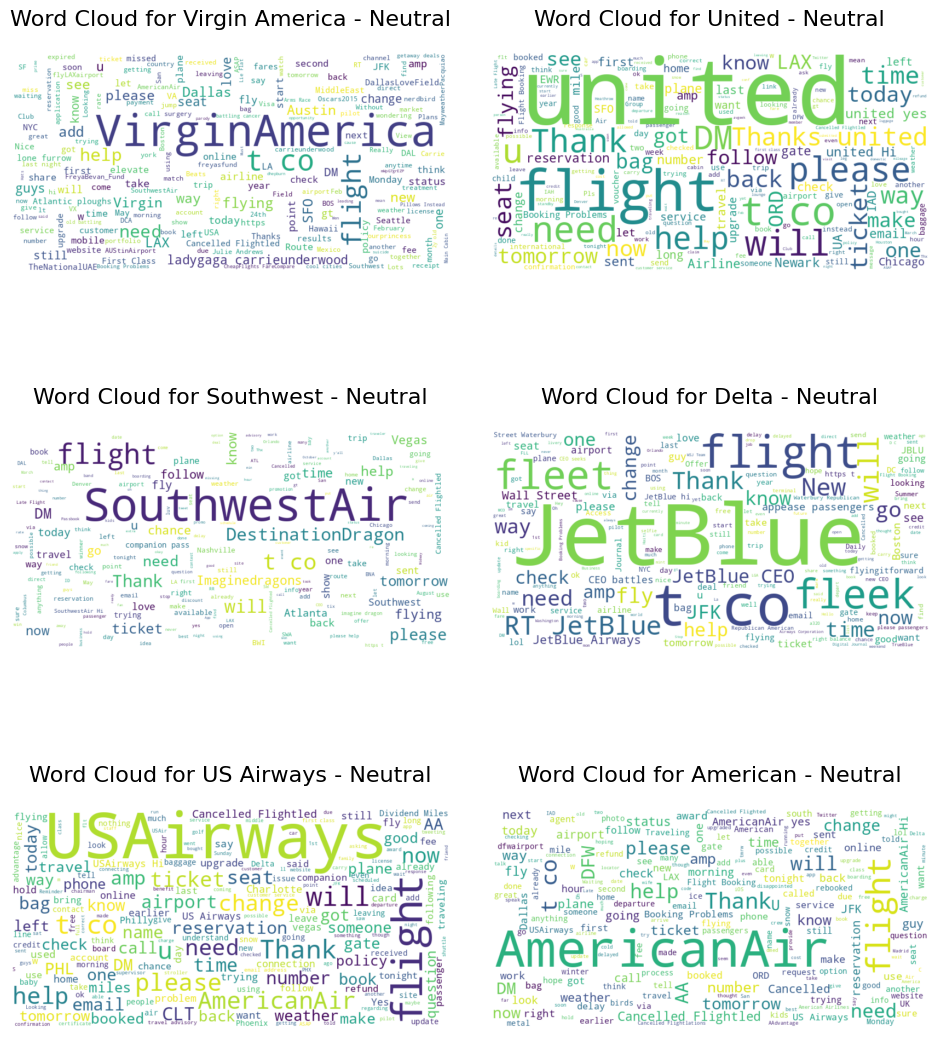

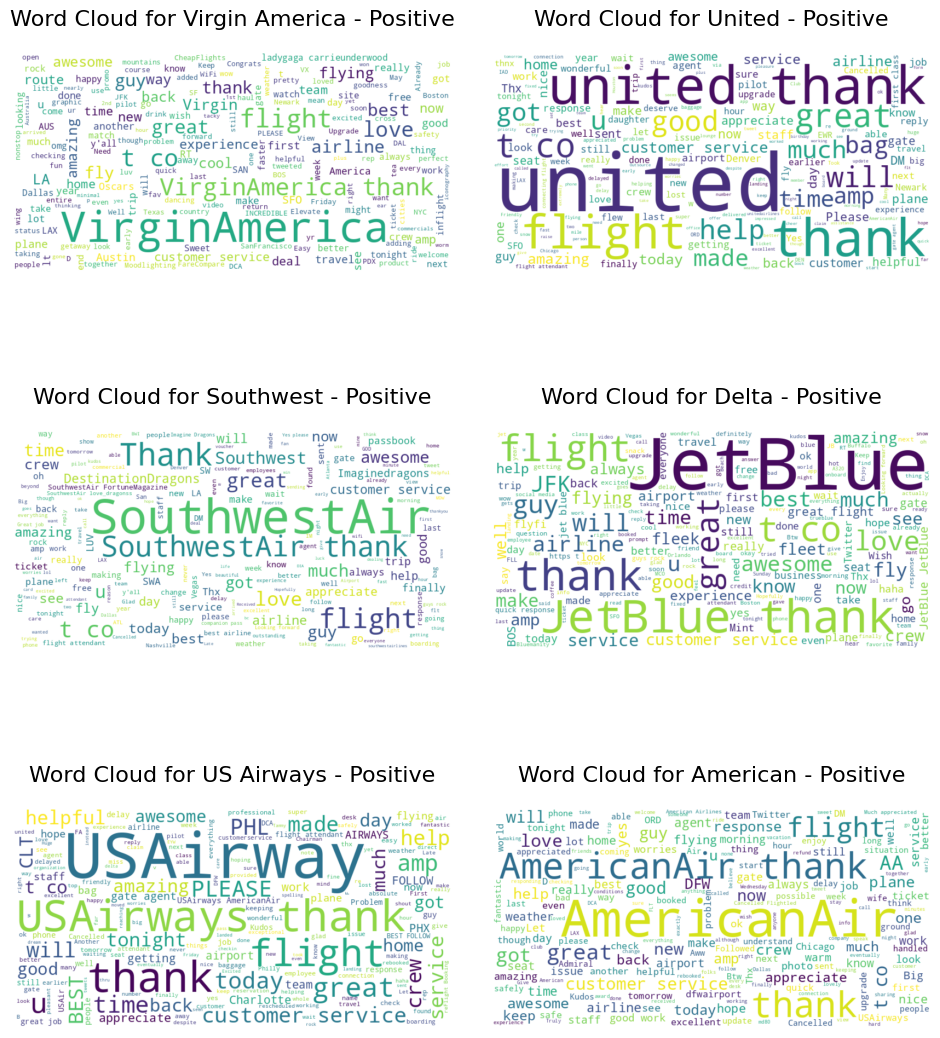

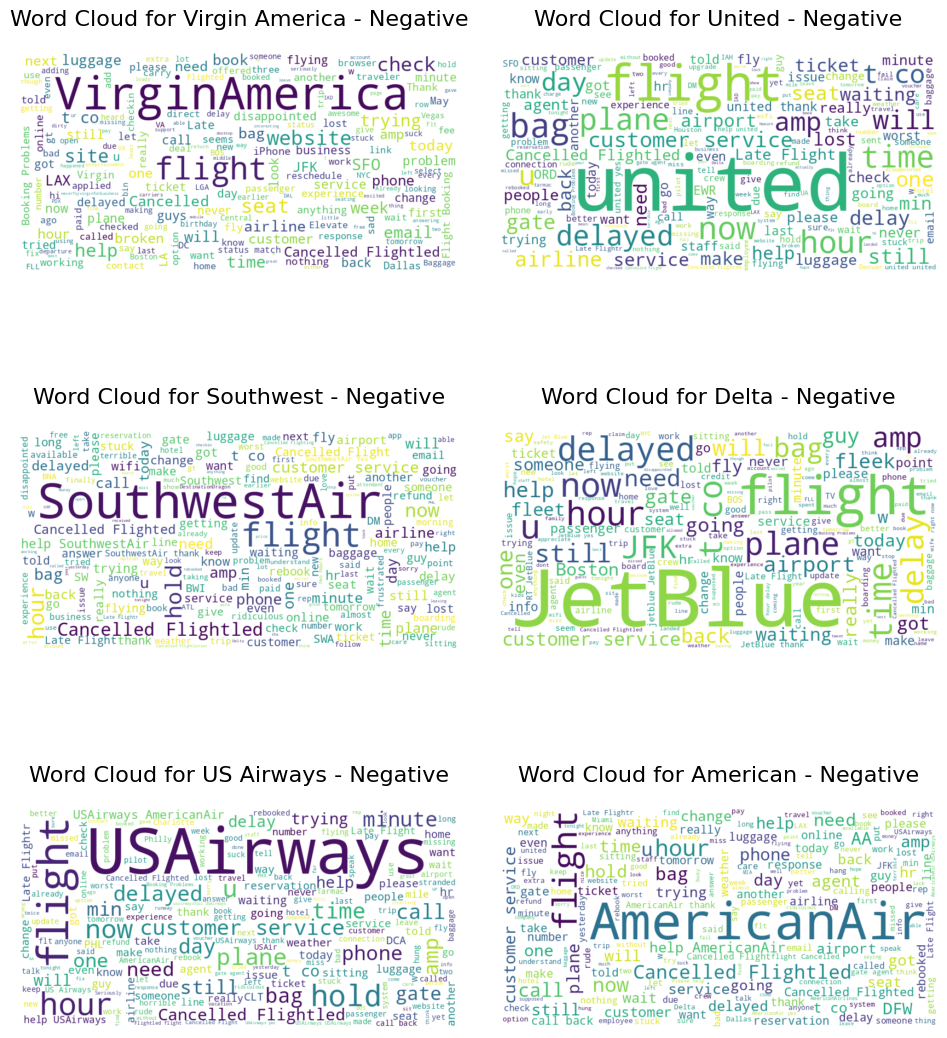

In [ ]:
def generate_and_plot_wordcloud(text, airline, sentiment, subplot_no):
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot word cloud
    plt.subplot(num_airlines // 2 + 1, 2, subplot_no)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {airline} - {sentiment.title()}', fontsize=16, pad=20)  # Add pad for title spacing
    plt.axis('off')

sentiments = df['airline_sentiment'].unique()
airlines = df['airline'].unique()
num_airlines = len(airlines)

for sentiment in sentiments:
    plt.figure(figsize=(10, 16))
    sentiment_airlines = df[df['airline_sentiment'] == sentiment]['airline'].unique()

    for i, airline in enumerate(airlines):
        text = " ".join(df[(df['airline_sentiment'] == sentiment) & (df['airline'] == airline)]['text'])
        generate_and_plot_wordcloud(text, airline, sentiment, i+1)

    plt.tight_layout(pad=3)  # Adjust spacing between subplots
    plt.show()


## Data Preprocessing

In this section, we're refining the dataset to keep only the columns of interest. We're focusing on the 'text' column, which contains the actual text of the tweet, and the 'airline_sentiment' column, which contains the sentiment expressed in the tweet. This sentiment is what we'll aim to predict with our model.

After selecting the necessary columns, we display the first few rows of the updated dataframe to confirm our changes.

In [ ]:
# Just keeping the required columns
df = df[['text', 'airline_sentiment']]

print(df.head())

                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative


## Assessing Word Lengths Before Data Cleaning

In this step, we're adding a new column to our dataframe, 'len', which will contain the length of each tweet. This is done by applying a lambda function to the 'text' column, where the function calculates the length of each tweet.

By calculating the length of the tweets before any data cleaning, we can gain some initial insights into the size and structure of the tweets we're working with. This might also give us some early ideas about the complexity of the text we're dealing with, and how much data cleaning might be required.

After adding the new column, we display the first few rows of the updated dataframe to verify our changes

In [ ]:
df['len'] = df['text'].apply(lambda x: len(x))
df.head()

,text,airline_sentiment,len
0,@VirginAmerica What @dhepburn said.,neutral,35
1,@VirginAmerica plus you've added commercials t...,positive,72
2,@VirginAmerica I didn't today... Must mean I n...,neutral,71
3,@VirginAmerica it's really aggressive to blast...,negative,126
4,@VirginAmerica and it's a really big bad thing...,negative,55


## Text Cleaning

In this step, we're cleaning the text data to prepare it for further analysis and modelling. We're defining a preprocessing function and applying it to every tweet in our dataset. The steps involved in the text cleaning process include:

Converting to Lower Case: All the text is converted to lower case. This is done to avoid having multiple copies of the same words. For example, 'Hello', 'HELLO', 'hello' are the same word but would be interpreted differently.

Removing Numbers: We remove numbers as they usually don't carry much meaningful information for sentiment analysis.

Lemmatization: This is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form. For example, 'running' is converted to 'run'. We use the WordNet Lemmatizer from the NLTK library for this purpose.

Removing Punctuation: Punctuation can provide grammatical context to a sentence, but for our purposes, they usually don't carry much information, so we remove them.

Removing Stopwords: Stopwords are common words that don't carry much meaningful information (e.g., 'is', 'and', 'the'). We use the list of English stopwords provided by the NLTK library.

Removing Single Characters: Single characters could occur due to the previous preprocessing steps (e.g., 'I' becoming 'i' then getting isolated after removing surrounding stopwords). These usually don't carry meaningful information, so we remove them.

Removing Extra Whitespaces: Extra whitespaces could be left over after the previous preprocessing steps, and we remove them here.

After defining the preprocessing function, we apply it to each tweet in our dataset.

In [ ]:
def preprocess_text(text):
    # convert to lower case
    text = text.lower()

    # remove numbers
    num_pattern = r'\d+'
    text = re.sub(pattern=num_pattern, repl=" ", string=text)

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemm_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemm_word
    text = " ".join(tokens)

    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove stopwords
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    text = " ".join(removed)

    # remove extra whitespaces
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    text = re.sub(pattern=single_char_pattern, repl=" ", string=text)

    return text

# Apply the preprocessing function to each text in the dataframe
df['text'] = df['text'].apply(preprocess_text)


## Assessing Word Lengths After Data Cleaning

After cleaning the text data, we now add another new column to our dataframe, 'new_len', which will contain the length of each cleaned tweet. This is done by applying a lambda function to the 'text' column, where the function calculates the length of each cleaned tweet.

By comparing the lengths of the tweets before and after cleaning, we can get an idea of how much our text data was reduced by the cleaning process. This could give us some insights into how much 'noise' was present in our original data, and how effective our cleaning process was.

After adding the new column, we display the first few rows of the updated dataframe to verify our changes.

In [ ]:
df['new_len'] = df['text'].apply(lambda x: len(x))
df.head()

,text,airline_sentiment,len,new_len
0,virginamerica dhepburn said,neutral,35,27
1,virginamerica plus added commercial experience...,positive,72,52
2,virginamerica nt today must mean need take ano...,neutral,71,55
3,virginamerica really aggressive blast obnoxiou...,negative,126,92
4,virginamerica really big bad thing,negative,55,34


## Mapping sentiment to labels

In this code snippet, a sentiment mapping is performed on the 'airline_sentiment' column of the DataFrame (df). The goal is to convert the sentiment values ('neutral', 'negative', 'positive') into numerical labels for further analysis or modeling purposes.

In [ ]:
label_map = {'neutral': 0, 'negative': 1, 'positive': 2}

df['airline_sentiment'] = df['airline_sentiment'].map(label_map)
df.head()

,text,airline_sentiment,len,new_len
0,virginamerica dhepburn said,0,35,27
1,virginamerica plus added commercial experience...,2,72,52
2,virginamerica nt today must mean need take ano...,0,71,55
3,virginamerica really aggressive blast obnoxiou...,1,126,92
4,virginamerica really big bad thing,1,55,34


## Train-Test Split for Text Classification

This code snippet demonstrates the train-test split process for a text classification task using the DataFrame df. The goal is to divide the data into training and testing subsets to evaluate the performance of a text classifier.

In [ ]:
df_train, df_test = train_test_split(df[['text', 'airline_sentiment']], test_size=0.3, random_state=42)
df_train.head()

,text,airline_sentiment
7717,jetblue flight sxm gt jfk time doe bus leave h...,0
13854,americanair still selling ticket nt rebooked p...,1
11719,usairways called time last three day unaccepta...,1
239,virginamerica sound like fun,2
8582,jetblue statement lufthansa incentive offer st...,0


## Naive Bayes Text Classification

This code snippet performs the training and evaluation of a Naive Bayes model for text classification. The model is tested without any text augmentation techniques.

In [ ]:
# Vectorizing the text
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(df_train['text'])
X_test_vec = vectorizer.transform(df_test['text'])

# Encoding the labels
y_train = df_train['airline_sentiment']
y_test = df_test['airline_sentiment']

# Train the Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vec, y_train)

# Make predictions
y_train_pred = naive_bayes_model.predict(X_train_vec)
y_test_pred = naive_bayes_model.predict(X_test_vec)

# Check the accuracy of the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy*100}%")
print(f"Testing Accuracy: {test_accuracy*100}%")

# Print classification report for training data
print("\nClassification report for training data:\n", classification_report(y_train, y_train_pred))

# Print classification report for testing data
print("\nClassification report for testing data:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 73.47775175644028%
Testing Accuracy: 69.35336976320583%

Classification report for training data:
               precision    recall  f1-score   support

           0       0.91      0.30      0.45      2215
           1       0.71      1.00      0.83      6364
           2       0.95      0.31      0.47      1669

    accuracy                           0.73     10248
   macro avg       0.86      0.54      0.58     10248
weighted avg       0.79      0.73      0.69     10248


Classification report for testing data:
               precision    recall  f1-score   support

           0       0.75      0.14      0.24       884
           1       0.68      0.99      0.81      2814
           2       0.92      0.18      0.30       694

    accuracy                           0.69      4392
   macro avg       0.79      0.44      0.45      4392
weighted avg       0.73      0.69      0.61      4392



## Creating a Copy of the Training Data

After testing the NaiveBayes model without text augmentation, the code snippet creates a copy of the df_train DataFrame and assigns it to a new DataFrame called new_df. This step allows for further manipulation or modifications to be made on the copied data without affecting the original training data.

In [ ]:
new_df = df_train.copy()
new_df.head()

,text,airline_sentiment
7717,jetblue flight sxm gt jfk time doe bus leave h...,0
13854,americanair still selling ticket nt rebooked p...,1
11719,usairways called time last three day unaccepta...,1
239,virginamerica sound like fun,2
8582,jetblue statement lufthansa incentive offer st...,0


## ContextualWordEmbsAug Initialization

In this code snippet, an instance of the ContextualWordEmbsAug class is initialized for text augmentation. The model used is '**bert-base-uncased**', and the augmentation action is set to 'insert'.

The ContextualWordEmbsAug class is part of the aug module and is used for text augmentation based on contextual word embeddings. In this case, the model 'bert-base-uncased' is specified as the contextual word embedding model. This model is pretrained on a large corpus and allows for contextual understanding of word meanings within the given text.

The action parameter is set to 'insert', which means that the augmentation process will focus on inserting additional words into the text to enhance its variety and diversity.

By initializing the ContextualWordEmbsAug class with the specified model and action, we can use the augment() method of this object to perform text augmentation on our data.

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert')

## Data Augmentation Function

The following code snippet defines a function named augmentMyData that performs data augmentation using a specified augmenter. Here is a breakdown of the function:

The augmentMyData function takes the following parameters:

**df**: The DataFrame containing the original data.<br>
**augmenter**: The augmenter object used for data augmentation.<br>
**label**: The sentiment label for which data augmentation will be performed (default is 0).<br>
**repetitions**: The number of times each sample will be augmented (default is 1).<br>
**samples**: The number of samples to be randomly selected for augmentation (default is 900).<br>

<br>Here is an overview of the steps performed by the function:<br>

1. Initialize an empty list called augmented_texts to store the augmented text samples.
2. Filter the DataFrame df to retrieve the rows with the specified label value in the 'airline_sentiment' column. The filtered DataFrame is assigned to label_df.
3. Use a loop to randomly select samples indices from label_df.
4. For each selected index, use another loop to perform repetitions augmentations on the corresponding text.
5. Append each augmented text to the augmented_texts list.
6. Create a dictionary data with keys 'airline_sentiment' and 'text', and values label and augmented_texts, respectively.
7. Create a new DataFrame aug_df from the data dictionary.
8. Shuffle the original DataFrame df appended with aug_df, and reset the index.
9. Return the shuffled DataFrame.

<p>By calling this function with appropriate arguments, you can perform data augmentation on a specific sentiment label within the provided DataFrame. The augmented data will be added to the original DataFrame, resulting in an expanded dataset for further analysis or model training.</p>

In [ ]:
def augmentMyData(df, augmenter, label=0, repetitions=1, samples=900):
    augmented_texts = []
    label_df = df[df['airline_sentiment']==label].reset_index(drop=True)

    for i in tqdm(np.random.randint(0, len(label_df), samples)):
        for _ in range(repetitions):
            augmented_text = augmenter.augment(label_df['text'].iloc[i])
            # if the augmenter returns a list of strings, join them into a single string
            if isinstance(augmented_text, list):
                augmented_text = ' '.join(augmented_text)
            augmented_texts.append(augmented_text)

    data = {'airline_sentiment':label, 'text': augmented_texts}

    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df


### Checking Data Count for Each Sentiment (Before Text Augmentation)

Before applying text augmentation, it is important to check the data count for each sentiment label in the new_df DataFrame. This allows you to understand the distribution of sentiments in the dataset. Here are the counts for each sentiment label:

Sentiment Label 1: 6364<br>
Sentiment Label 0: 2215<br>
Sentiment Label 2: 1669<br>

These counts indicate the number of samples corresponding to each sentiment label in the airline_sentiment column of the new_df DataFrame.

By examining the data count for each sentiment, we can gain insights into the class distribution and determine if any class imbalance exists in the dataset. This information is useful for evaluating the need for data augmentation or implementing appropriate strategies to address class imbalance. It is quite evident from the value_counts() both Class 0 and Class 2 samples are significantly low and when you train a model on an imbalanced dataset, the model will learn to overfit to the majority class. This means that the model will be very good at predicting the majority class, but it will not be very good at predicting the minority class.

This is because the model will see more examples of the majority class in the training data, and it will learn to focus on the features that are most predictive of the majority class. As a result, the model will not learn to pay attention to the features that are most predictive of the minority class.

In [ ]:
new_df['airline_sentiment'].value_counts()

1    6364
0    2215
2    1669
Name: airline_sentiment, dtype: int64

### Data Augmentation for Sentiment Label 0

In the code snippet, the augmentMyData function is called on the new_df DataFrame to perform data augmentation specifically for sentiment label 0.

After the augmentation, we can see the increased value_counts for class label 0.

In [ ]:
aug_df = augmentMyData(new_df, augmenter, samples=3000)   # Augmenting data for label 0
print('\n')
aug_df['airline_sentiment'].value_counts()

100%|██████████| 3000/3000 [11:21<00:00,  2.02it/s]


<ipython-input-25-bc1a692caa23>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(aug_df).reset_index(drop=True))
0    5215
1    6364
2    1669
Name: airline_sentiment, dtype: int64


### Data Augmentation for Sentiment Label 2

Similar to the above step, we now augment samples for class label 2

In [ ]:
aug_df = augmentMyData(aug_df, augmenter, label=2, samples=3000)  # Augmenting data for label 2
print('\n')
aug_df['airline_sentiment'].value_counts()

100%|██████████| 3000/3000 [13:04<00:00,  2.13it/s]


<ipython-input-25-bc1a692caa23>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(aug_df).reset_index(drop=True))
0    5215
2    4669
1    6364
Name: airline_sentiment, dtype: int64


In [ ]:
# aug_df.to_csv('aug_df_tweets.csv') # Uncomment this code if you want to save the augmented dataset to a csv file

## Testing with Naive Bayes after Text Augmentation

We now test the Naive Bayes model after applying text augmentation. 

Here is a step-by-step explanation of the code:

1. The TfidfVectorizer is instantiated and fitted on the augmented training data aug_df['text'].<br>
2. The augmented training data is vectorized using the fitted vectorizer, resulting in X_train_aug_vec.<br>
3. The test data df_test['text'] is vectorized using the same vectorizer, producing X_test_vec.<br>
4. The labels of the augmented training data are extracted and assigned to y_train_aug.<br>
5. A MultinomialNB model is created and trained on the augmented training data, using X_train_aug_vec and y_train_aug.<br>
6. Predictions are made on the augmented training data (X_train_aug_vec) and the original testing data (X_test_vec).<br>
7. One-hot encoded labels of the original testing data are converted to single integers, resulting in y_test_labels.<br>
8. The accuracy of the model is calculated by comparing the predicted labels with the true labels for both the augmented training data and the original testing data.<br>
9. The training accuracy and testing accuracy are printed using print() statements.<br>
10. The classification report is printed for the augmented training data using classification_report() with y_train_aug and y_train_aug_pred.<br>
11. The classification report is printed for the original testing data using classification_report() with y_test_labels and y_test_pred_aug.<br>

By executing this code, you can evaluate the performance of the Naive Bayes model after applying text augmentation. The accuracy and classification reports provide insights into the model's performance on both the augmented training data and the original testing data.

In [ ]:
# Fit the vectorizer on the augmented training data
vectorizer = TfidfVectorizer()
vectorizer.fit(aug_df['text'])

# Vectorize the augmented training data
X_train_aug_vec = vectorizer.transform(aug_df['text'])

# Vectorize the test data using the same vectorizer
X_test_vec = vectorizer.transform(df_test['text'])

# Get the labels of the augmented training data
y_train_aug = aug_df['airline_sentiment']

# Train the Naive Bayes model on the augmented training data
naive_bayes_model_aug = MultinomialNB()
naive_bayes_model_aug.fit(X_train_aug_vec, y_train_aug)

# Make predictions on the augmented training data and the original testing data
y_train_aug_pred = naive_bayes_model_aug.predict(X_train_aug_vec)
y_test_pred_aug = naive_bayes_model_aug.predict(X_test_vec)
# Convert one-hot encoded labels to single integers
y_test_labels = np.argmax(y_test, axis=1)

# Check the accuracy of the model on the augmented training data and the original testing data
train_aug_accuracy = accuracy_score(y_train_aug, y_train_aug_pred)
test_accuracy_aug = accuracy_score(y_test_labels, y_test_pred_aug)

print(f"Training Accuracy with Augmented Data: {train_aug_accuracy*100}%")
print(f"Testing Accuracy with Original Data: {test_accuracy_aug*100}%")

# Print classification report for augmented training data
print("\nClassification report for augmented training data:\n", classification_report(y_train_aug, y_train_aug_pred))

# Print classification report for original testing data
print("\nClassification report for original testing data:\n", classification_report(y_test_labels, y_test_pred_aug))


Training Accuracy with Augmented Data: 91.08060055314105%
Testing Accuracy with Original Data: 78.00546448087432%

Classification report for augmented training data:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      5215
           1       0.91      0.93      0.92      6364
           2       0.91      0.93      0.92      4669

    accuracy                           0.91     16248
   macro avg       0.91      0.91      0.91     16248
weighted avg       0.91      0.91      0.91     16248


Classification report for original testing data:
               precision    recall  f1-score   support

           0       0.60      0.53      0.56       884
           1       0.85      0.88      0.87      2814
           2       0.69      0.68      0.68       694

    accuracy                           0.78      4392
   macro avg       0.71      0.70      0.70      4392
weighted avg       0.77      0.78      0.78      4392


## Results of NaiveBayes after text augmentation:

The results of the Naive Bayes model after applying text augmentation show significant improvements in both training and testing accuracy compared to the results before augmentation.

Before text augmentation, the training accuracy was 73.48% and the testing accuracy was 69.35%. However, after applying text augmentation, the training accuracy increased to 91.08% and the testing accuracy improved to 78.01%.

The classification reports provide further insights into the performance of the model. Before augmentation, the precision, recall, and F1-scores were relatively low for some sentiment labels, particularly for label 0 and label 2. However, after augmentation, the precision, recall, and F1-scores improved significantly across all sentiment labels, resulting in a more balanced and accurate classification.

In summary, by applying text augmentation, the Naive Bayes model demonstrates notable enhancements in both training and testing accuracy, as well as improvements in precision, recall, and F1-scores for sentiment classification. These results highlight the effectiveness of text augmentation in enhancing the performance of the model and improving its ability to accurately classify sentiment in text data.

## Stacked Ensemble Approach for Sentiment Classification

The provided code implements a stacked ensemble approach for sentiment classification. 

Here's a brief summary of the code:

1. Tokenization and Conversion: The text data is tokenized using the Tokenizer class from Keras. The text sequences are then converted into sequences of numbers using the texts_to_sequences method.

2. Padding: The sequences are padded to ensure they have the same length using the pad_sequences function. This step is necessary to ensure consistent input shapes for the models.

3. LSTM and CNN Model Definition: Two different models, an LSTM model and a CNN model, are defined using the Keras Sequential API. Each model consists of embedding layers, recurrent or convolutional layers, and dense layers.

4. Training LSTM and CNN Models: The defined LSTM and CNN models are trained on the augmented training data using the fit method. The training process is controlled by the early_stop callback, which stops training if the validation loss does not improve after a certain number of epochs.

5. Training Random Forest Model: A Random Forest model is trained using the CountVectorizer-transformed augmented training data.

6. Obtaining Model Predictions: Predictions from the trained LSTM, CNN, and Random Forest models are obtained on the test data.

7. Concatenating Model Predictions: The predictions from the models are concatenated horizontally to create a meta-feature matrix.

8. Meta-Learner Model: A meta-learner model (a fully connected neural network) is defined and trained on the concatenated predictions from the previous step.

9. Evaluation: The trained meta-learner model is used to predict the sentiment labels for the validation set. The predictions are converted back from one-hot encoding to the original labels. The classification report is then printed, providing metrics such as precision, recall, and F1-score for each sentiment label.

In summary, the code implements a stacked ensemble approach where multiple models, including LSTM, CNN, and Random Forest, are trained independently, and their predictions are combined using a meta-learner model. This ensemble technique aims to leverage the strengths of different models to improve the overall sentiment classification performance.

In [ ]:
X_train_aug = aug_df['text']
X_test = df_test['text']

vocab_size = 8000  # Define vocab_size here

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_aug)  # Assuming X_train_aug is your training text data

# Converting text to sequence of numbers
sequences_train = tokenizer.texts_to_sequences(X_train_aug)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Convert labels to one-hot encoding for Keras models
label_binarizer = LabelBinarizer()
y_train_aug = label_binarizer.fit_transform(y_train_aug)
y_test = label_binarizer.transform(y_test)

max_len = 36

# Padding
padded_train = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')

# Define the LSTM model
def create_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(8000, 128, input_length=max_len), # Use max_len here
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(8000, 128, input_length=max_len), # Use max_len here
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Train LSTM and CNN models
models = [create_lstm_model(), create_cnn_model()]
for model in models:
    model.fit(padded_train, y_train_aug, epochs=10, validation_data=(padded_test, y_test), callbacks=[early_stop])  # Add early_stop callback

# Train Random Forest model
count_vectorizer = CountVectorizer(max_features=vocab_size)
X_train_aug_vec = count_vectorizer.fit_transform(X_train_aug)
X_test_vec = count_vectorizer.transform(X_test)

y_train_aug_labels = label_binarizer.inverse_transform(y_train_aug)
# y_test_labels = label_binarizer.inverse_transform(y_test)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_aug_vec, y_train_aug_labels)

# Get predictions from all models
model_outputs = [model.predict(padded_test) for model in models]
random_forest_output = random_forest_model.predict(X_test_vec.toarray())
random_forest_output_one_hot = label_binarizer.transform(random_forest_output)
model_outputs.append(random_forest_output_one_hot)

# Concatenate predictions
concatenated_predictions = np.concatenate(model_outputs, axis=-1)

# Split concatenated_predictions and y_test into training and validation sets for the meta-learner
concat_train, concat_val, y_train_meta, y_val_meta = train_test_split(concatenated_predictions, y_test, test_size=0.2, random_state=42)

# Define and train 'meta-learner' model
meta_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
meta_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
meta_model.fit(concat_train, y_train_meta, validation_data=(concat_val, y_val_meta), epochs=10, callbacks=[early_stop])  # Add early_stop callback

# Predict classes
y_pred = meta_model.predict(concat_val)
# Convert predictions back from one-hot encoding to original labels
y_pred_labels = label_binarizer.inverse_transform(y_pred)
# Convert validation data back from one-hot encoding to original labels
y_val_meta_labels = label_binarizer.inverse_transform(y_val_meta)

print(classification_report(y_val_meta_labels, y_pred_labels, zero_division=1))



Epoch 1/10
633/633 [==============================] - 327s 502ms/step - loss: 0.5846 - accuracy: 0.7563 - val_loss: 0.7715 - val_accuracy: 0.7070
Epoch 2/10
633/633 [==============================] - 324s 511ms/step - loss: 0.3339 - accuracy: 0.8750 - val_loss: 0.7314 - val_accuracy: 0.7678
Epoch 3/10
633/633 [==============================] - 321s 507ms/step - loss: 0.2653 - accuracy: 0.9041 - val_loss: 0.6562 - val_accuracy: 0.8065
Epoch 4/10
633/633 [==============================] - 322s 509ms/step - loss: 0.2312 - accuracy: 0.9164 - val_loss: 0.6354 - val_accuracy: 0.8396
Epoch 5/10
633/633 [==============================] - 323s 510ms/step - loss: 0.1914 - accuracy: 0.9290 - val_loss: 0.5873 - val_accuracy: 0.8593
Epoch 6/10
633/633 [==============================] - 319s 504ms/step - loss: 0.1703 - accuracy: 0.9391 - val_loss: 0.5496 - val_accuracy: 0.8623
Epoch 7/10
633/633 [==============================] - 317s 500ms/step - loss: 0.1453 - accuracy: 0.9466 - val_loss: 0.4709 -

The overall performance of the stacked ensemble model is quite good, with high accuracy and balanced F1-scores across the sentiment labels. The model shows promising results in correctly classifying sentiment in text data, achieving high precision, recall, and F1-scores for each sentiment category.